In [1]:
#モジュールのインポート
import os, glob, re
from datetime import date
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import gdal
import json, geojson
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import folium 
from PIL import Image
import earthpy.plot as ep
from shapely.geometry import Point, Polygon, box
import zipfile

/Users/skohei/.pyenv/versions/anaconda3-2023.03/envs/pythonGIS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentinelAPIを叩いてRegeon of Interestを含む衛星画像の表示

In [2]:
#関心領域の表示

edge_line = gpd.read_file("../raw_data/shapefile/suwako_line.geojson", encoding="shift-jis")

# 座標系をUTM Zone 54Nに変換します
edge_line_utm = edge_line.to_crs(epsg=32654)

# 最初のgeometryの座標を取得する（この例では最初のgeometryのみを取り扱っています）
coords = list(edge_line.iloc[0]['geometry'].exterior.coords)

# 座標を[[x, y], ...]の形式に変換する
output_coords = [[x, y] for x, y in coords]

In [3]:
m = folium.Map([(output_coords[0][1]+output_coords[len(output_coords)-1][1])/2,(output_coords[0][0]+output_coords[len(output_coords)-1][0])/2], zoom_start=10)

folium.GeoJson("../raw_data/shapefile/suwako_line.geojson").add_to(m)

m

In [4]:
# 座標のリストからPolygonを生成
polygon = Polygon(output_coords)

# PolygonのBounding Boxを取得
minx, miny, maxx, maxy = polygon.bounds

# Bounding Boxの四角形を生成
bounding_box = box(minx, miny, maxx, maxy)

In [5]:
user = 'koheisawano' 
password = 'pvnmrt273cvcpr' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [6]:
# データの取得
# 過去のデータはアーカイブとなりこのまま取得できないため、
# 「データがオンラインではありません」というエラーが発生する場合には、
# 日付部分を適宜新しくした上で実行するようにしてください

products = api.query(bounding_box,
                     date = ('20230901', '20230910'), # 取得希望期間の入力
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,50)) # 被雲率（0％〜100％）

In [7]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
1fd35c0b-74c7-44e8-bc73-0fa84852e791,S2B_MSIL2A_20230909T012659_N0509_R074_T53SQA_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2023-09-09T01:26:59.024Z, Instrument: MS...",false,2023-09-09 03:43:31,2023-09-09 01:26:59.024,2023-09-09 01:26:59.024,2023-09-09 06:28:21.523,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20230909T034331_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230909T034331_A0339...,S2B_MSIL2A_20230909T012659_N0509_R074_T53SQA_2...,1fd35c0b-74c7-44e8-bc73-0fa84852e791,"MULTIPOLYGON (((138.43659 36.00745, 138.48059 ..."


In [8]:
# APIでダウンロード

# ファイルが重いため、時間がかかります
# uuid = products_gdf_sorted.iloc[0]["uuid"]
# product_title = products_gdf_sorted.iloc[0]["title"]
# print(product_title)

In [9]:
# file_path = "../../../../../../Volumes/HD-PCFSU3-A/Sentinel_data/RawData/2022/7-9/8"
# files = os.listdir(os.getcwd())
# print(files)

In [10]:
print(os.getcwd())

/Users/skohei/Desktop/Shinshu-u-research/devs/pythonfiles


In [11]:
file_name = "S2A_MSIL2A_20220803T013701_N0400_R117_T53SQV_20220803T053807"
file_path = "../raw_data/"

os.chdir("../raw_data/")
with zipfile.ZipFile(file_name + ".zip") as zf:
  zf.extractall()
os.chdir("../pythonfiles/")
filePath = os.path.join(file_path,file_name) +  ".SAFE" # SAFEファイルの場所指定

path = os.path.join(filePath, 'GRANULE')
files = os.listdir(path)

pathA = os.path.join(filePath,'GRANULE',str(files[0]))
files2 = os.listdir(pathA)

pathB = os.path.join(filePath, 'GRANULE', str(files[0]),'IMG_DATA/R10m')
files3 = os.listdir(pathB)

fileNameList = glob.glob(pathB+'/*.jp2')
path_b2 = list(filter(lambda x: x.endswith('B02_10m.jp2'),fileNameList))[0]
path_b3 = list(filter(lambda x: x.endswith('B03_10m.jp2'),fileNameList))[0]
path_b4 = list(filter(lambda x: x.endswith('B04_10m.jp2'),fileNameList))[0]


b4 = rio.open(path_b4) # red
b3 = rio.open(path_b3) # green
b2 = rio.open(path_b2) # blue

b4.count, b4.width, b4.height

b4.crs

CRS.from_epsg(32653)

In [12]:
object_name = "Suwako"
with rio.open(str(object_name) +'.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),1) 
    rgb.close()

RGB_tokyo =rio.open(str(object_name) +'.tiff')
RGB_tokyo.crs

nReserve_geo = edge_line
epsg = b4.crs

/Users/skohei/.pyenv/versions/anaconda3-2023.03/envs/pythonGIS/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


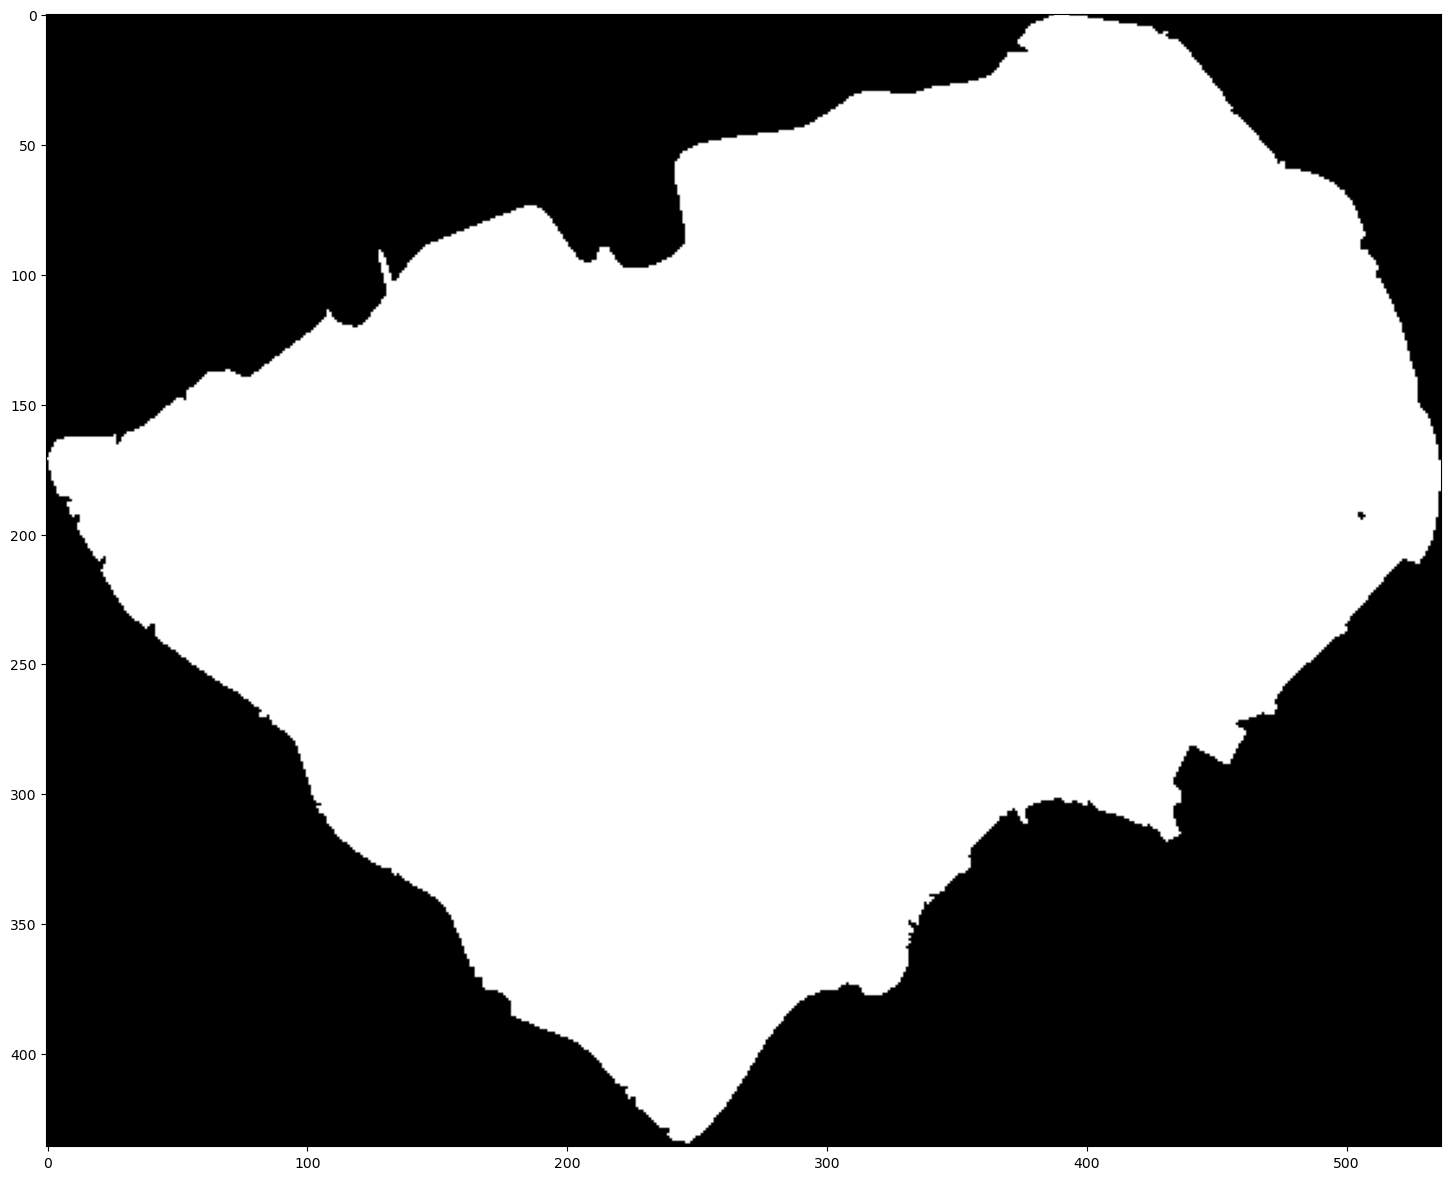

In [13]:
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

with rio.open(str(object_name) +'.tiff') as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open('Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
    dest.write(out_image)

msk = rio.open(r'Masked_' +str(object_name) +'.tif')
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show();

In [14]:
imgTif = 'Masked_' +str(object_name) +'.tif' # 読み出し用Tiffのパス
imgJpg = 'Masked_' +str(object_name) +'.jpg' # 書き出し用jpgのパスs


with rio.open(imgTif) as src:
  img_array = src.read() # 配列情報の読み取り

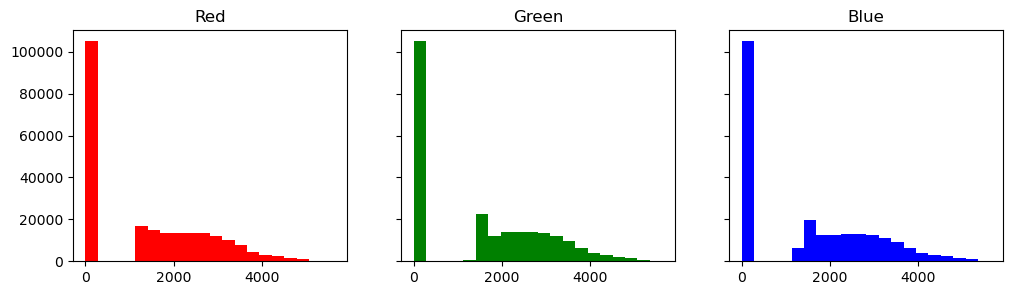

In [15]:
ep.hist(img_array,
        colors=['r', 'g', 'b'],
        title=['Red', 'Green', 'Blue'],
        cols=3,
        figsize=(12, 3));

/Users/skohei/.pyenv/versions/anaconda3-2023.03/envs/pythonGIS/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


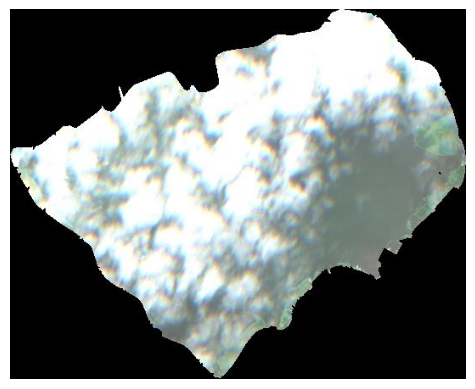

In [16]:
# gdal.Translate(imgJpg, imgTif, format='GTiff', scaleParams=[[0,3000,0,255]])
# # scaleParamsの部分は空白[[]]でも動作します。その場合は、gdal.Translateが自動で最適なコントラストに設定しますが、多くの場合手動でやるほうが良い結果になります
# im = Image.open('Masked_' +str(object_name) +'.jpg')
# im

# やや長いですが、下記方法でも変換可能です（より厳密な定義）
scale = '-scale 0 3000 0 255' # 画像の色調整を行います(16bitから8bit範囲へ変換)
options_list = [
    '-ot Byte', # 8bitまで扱う
    '-of JPEG', # 変換後の画像フォーマット
    scale # 画像のコントラスト
] 
options_string = " ".join(options_list)

gdal.Translate(imgJpg, # 変換後の画像（パスごと記入）
               imgTif, # 変換元の画像
               options=options_string) # オプション指定

# 画像を開く
image_path = imgJpg
img = Image.open(image_path)

# 画像を表示
plt.imshow(img)
plt.axis('off')  # 座標軸を非表示にする
plt.show()
     

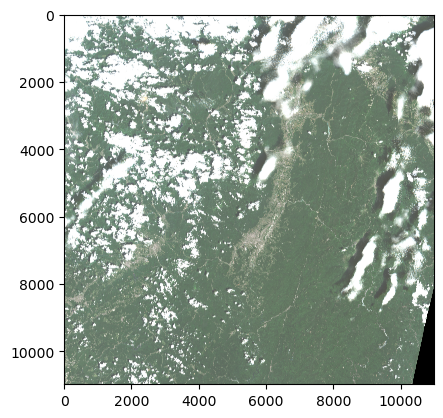

<Axes: >

In [17]:
# rio.openされたjp2ファイルを配列化
b, g, r = b2.read(1), b3.read(1), b4.read(1)
imgArray = np.array([r, g, b])

# RGB画像の最大値を調整（見た目を良くする作業）
imgArray[imgArray > 3000] = 3000
img = ((imgArray / imgArray.max()) * 255).astype(np.uint8)
rio.plot.show(img)
     


ここから先はtiffの表示及び，ピクセル値のgpd入力とポリゴンでの切り出し

In [18]:
OW_C = gpd.read_file("../raw_data/shapefile/OW_C.geojson")

# 座標系をUTM Zone 54Nに変換します

OW_C.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
OW_C = OW_C.to_crs("EPSG:32654")
OW_C

,geometry
0,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."


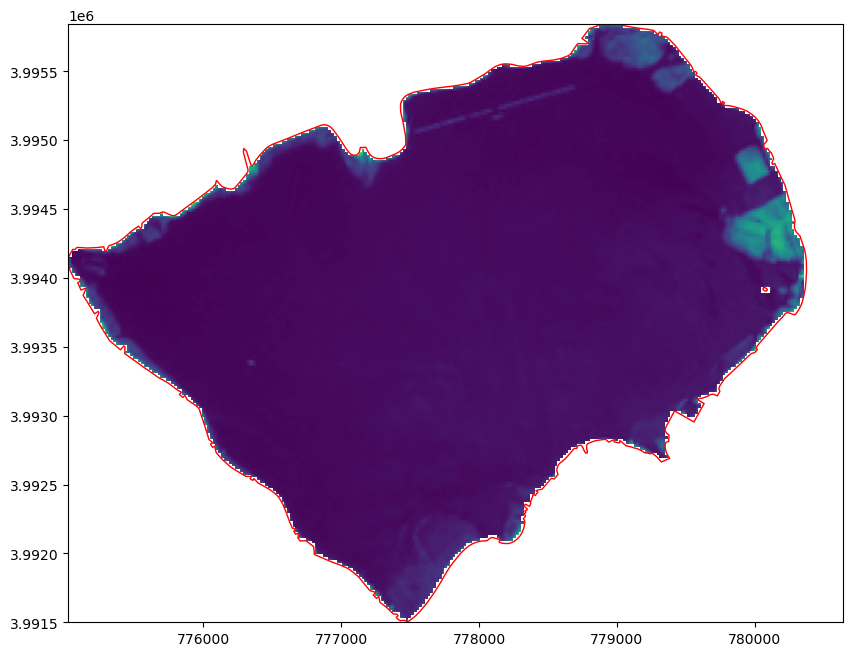

In [20]:
# TIFFファイル表示
open_tifffile_path = "../raw_data/2021_06_01_suwako.tif"
# open_tifffile_path = "Masked_Suwako.tif"

# GeoTIFFファイルを読み込みます
with rasterio.open(open_tifffile_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    edge_line_utm = edge_line.to_crs(src.crs)
    OW_C_utm = OW_C.to_crs(src.crs)
    # tiffファイルを表示
    show(src, ax=ax)
    # edge_line_utmを同じプロットに追加
    edge_line_utm.plot(ax=ax, edgecolor='red', facecolor='none')
    OW_C.plot(ax=ax, edgecolor='red', facecolor='none')
    plt.show()

In [21]:
# GeoJSONファイルを読み込みます
edge_line = gpd.read_file("../raw_data/shapefile/suwako_line.geojson", encoding="shift-jis")

# 座標系をUTM Zone 54Nに変換します
edge_line_utm = edge_line.to_crs(epsg=32654)

# 変換後のgeometry属性を確認します
print(edge_line_utm["geometry"])

0    POLYGON ((237270.828 3994915.044, 237204.739 3...
Name: geometry, dtype: geometry


In [22]:
with rasterio.open(open_tifffile_path) as src:
    transform = src.transform
    
    # バンドのメタデータの取得
    band_descriptions = [src.descriptions[i-1] for i in range(1, src.count + 1)]
    
    # 各バンドを読み込む
    bands_data = []
    for i in range(1, src.count + 1):
        bands_data.append(src.read(i))

# バンドの形状から座標を取得
height, width = bands_data[0].shape
xs, ys = np.meshgrid(np.arange(width), np.arange(height))
x_coords = (xs * transform[0]) + transform[2]
y_coords = (ys * transform[4]) + transform[5]

# GeoDataFrameの作成
geometry = [Point(xy) for xy in zip(x_coords.flatten(), y_coords.flatten())]
df = {'geometry': geometry}

# 各バンドの値をDataFrameの列として追加
for i, (band_data, band_description) in enumerate(zip(bands_data, band_descriptions)):
    # バンドの説明が存在しない場合は、デフォルトの名前を使用
    col_name = band_description if band_description else f'band_{i+1}'
    df[col_name] = band_data.flatten()

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=src.crs)
polygon = Polygon(output_coords)

polygon_gdf = gpd.GeoDataFrame([polygon], columns=['geometry'], geometry='geometry', crs="EPSG:4326") 
polygon_gdf = polygon_gdf.to_crs(gdf.crs)
sub_gdf = gdf[gdf.within(polygon_gdf.iloc[0].geometry)]


In [23]:
sub_gdf

,geometry,"B5, central wavelength 705 nm","B6, central wavelength 740 nm","B7, central wavelength 783 nm","B8A, central wavelength 865 nm","B11, central wavelength 1610 nm","B12, central wavelength 2190 nm","AOT, Aerosol Optical Thickness map (at 550nm)","CLD, Raster mask values range from 0 for high confidence clear sky to 100 for high confidence cloudy","SCL, Scene Classification","SNW, Raster mask values range from 0 for high confidence NO snow/ice to 100 for high confidence snow/ice","WVP, Scene-average Water Vapour map"
193,POINT (778880.000 3995840.000),738,1529,1632,1703,1079,660,102,0,4,0,1088
194,POINT (778900.000 3995840.000),663,1344,1302,1527,932,490,102,0,4,0,1010
195,POINT (778920.000 3995840.000),588,1231,1365,1322,939,490,102,0,4,0,1010
196,POINT (778940.000 3995840.000),644,1285,1581,1475,980,513,102,0,4,0,1010
197,POINT (778960.000 3995840.000),772,1422,1868,1617,1109,637,102,0,4,0,1010
...,...,...,...,...,...,...,...,...,...,...,...,...
57792,POINT (777420.000 3991520.000),0,0,0,0,0,0,0,0,0,0,0
57793,POINT (777440.000 3991520.000),0,0,0,0,0,0,0,0,0,0,0
57794,POINT (777460.000 3991520.000),760,921,1212,1083,826,583,102,0,2,0,1010
57795,POINT (777480.000 3991520.000),951,1026,788,884,935,642,102,0,2,0,1010


In [ ]:
init